In [1]:
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.functional as F
import torch.nn as nn
import torchvision
import torchvision.transforms as tvtransforms
import torchvision.utils as vutils

In [2]:
# Batch size
bsize = 64
epochs = 20
lr = 0.0002
b1 = 0.5
b2 = 0.999
nz = 100

img_shape = (1, 28, 28)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
os.makedirs("data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "data/mnist",
        train=True,
        download=True,
        transform=tvtransforms.Compose(
            [tvtransforms.ToTensor(), tvtransforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=bsize,
    num_workers=2,
    shuffle=True,
)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(nz, 128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh(),
        )
        
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        return self.model(img.view(img.size(0), -1))

In [6]:
gnet = Generator().to(device)
print(gnet)
dnet = Discriminator().to(device)
print(dnet)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace

In [7]:
criterion = nn.BCELoss()
real_label = 1
fake_label = 0
gopt = torch.optim.Adam(gnet.parameters(), lr=lr, betas=(b1, b2))
dopt = torch.optim.Adam(dnet.parameters(), lr=lr, betas=(b1, b2))

In [8]:
fixed_noise = torch.randn(64, nz, device=device)

In [9]:
g_losses = []
d_losses = []
img_list = []
iters = 0

fake = gnet(fixed_noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader, 0):
        dnet.zero_grad()
        imgs = imgs.to(device)
        nb = imgs.size(0)
        label = torch.full((nb,), real_label, device=device)
        output = dnet(imgs)
        derr_real = criterion(output, label)
        derr_real.backward()
        dx = output.mean().item()
        
        noise = torch.randn(nb, nz, device=device)
        fake = gnet(noise)
        label.fill_(fake_label)
        output = dnet(fake.detach())
        derr_fake = criterion(output, label)
        derr_fake.backward()
        dg_z1 = output.mean().item()
        derr = (derr_real + derr_fake) / 2
        dopt.step()
        
        gnet.zero_grad()
        label.fill_(real_label)
        output = dnet(fake).view(-1)
        gerr = criterion(output, label)
        gerr.backward()
        dg_z2 = output.mean().item()
        gopt.step()
        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     derr.item(), gerr.item(), dx, dg_z1, dg_z2))
        if (iters % 500 == 0) or ((epoch == epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = gnet(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        g_losses.append(gerr.item())
        d_losses.append(derr.item())
        iters += 1

/home/fred/anaconda3/envs/main/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[0/20][0/938]	Loss_D: 0.7126	Loss_G: 0.7135	D(x): 0.5118	D(G(z)): 0.5127 / 0.4940
[0/20][50/938]	Loss_D: 0.6656	Loss_G: 0.7510	D(x): 0.5152	D(G(z)): 0.4837 / 0.4730
[0/20][100/938]	Loss_D: 0.6205	Loss_G: 0.8107	D(x): 0.5373	D(G(z)): 0.4569 / 0.4455
[0/20][150/938]	Loss_D: 0.5791	Loss_G: 0.8536	D(x): 0.5653	D(G(z)): 0.4403 / 0.4272
[0/20][200/938]	Loss_D: 0.5460	Loss_G: 0.9165	D(x): 0.5867	D(G(z)): 0.4233 / 0.4020
[0/20][250/938]	Loss_D: 0.5063	Loss_G: 1.0207	D(x): 0.6195	D(G(z)): 0.4064 / 0.3658
[0/20][300/938]	Loss_D: 0.4528	Loss_G: 1.1152	D(x): 0.6322	D(G(z)): 0.3508 / 0.3335
[0/20][350/938]	Loss_D: 0.4900	Loss_G: 1.0573	D(x): 0.6298	D(G(z)): 0.3863 / 0.3547
[0/20][400/938]	Loss_D: 0.6019	Loss_G: 0.9381	D(x): 0.5447	D(G(z)): 0.4376 / 0.3956
[0/20][450/938]	Loss_D: 0.5750	Loss_G: 0.9794	D(x): 0.5699	D(G(z)): 0.4308 / 0.3831
[0/20][500/938]	Loss_D: 0.6343	Loss_G: 0.8842	D(x): 0.5242	D(G(z)): 0.4448 / 0.4196
[0/20][550/938]	Loss_D: 0.6313	Loss_G: 0.8480	D(x): 0.5480	D(G(z)): 0.4757 / 0.

/home/fred/anaconda3/envs/main/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/20][0/938]	Loss_D: 0.6028	Loss_G: 0.8932	D(x): 0.5553	D(G(z)): 0.4442 / 0.4168
[1/20][50/938]	Loss_D: 0.6008	Loss_G: 0.8857	D(x): 0.5498	D(G(z)): 0.4400 / 0.4190
[1/20][100/938]	Loss_D: 0.5995	Loss_G: 0.9404	D(x): 0.5431	D(G(z)): 0.4246 / 0.3978
[1/20][150/938]	Loss_D: 0.6138	Loss_G: 0.9280	D(x): 0.5326	D(G(z)): 0.4343 / 0.4025
[1/20][200/938]	Loss_D: 0.5961	Loss_G: 0.8790	D(x): 0.5705	D(G(z)): 0.4535 / 0.4222
[1/20][250/938]	Loss_D: 0.5877	Loss_G: 0.8605	D(x): 0.5643	D(G(z)): 0.4436 / 0.4272
[1/20][300/938]	Loss_D: 0.6242	Loss_G: 0.8587	D(x): 0.5446	D(G(z)): 0.4603 / 0.4304
[1/20][350/938]	Loss_D: 0.6463	Loss_G: 0.9059	D(x): 0.4915	D(G(z)): 0.4289 / 0.4129
[1/20][400/938]	Loss_D: 0.6333	Loss_G: 0.8931	D(x): 0.5096	D(G(z)): 0.4285 / 0.4144
[1/20][450/938]	Loss_D: 0.6140	Loss_G: 0.8789	D(x): 0.5490	D(G(z)): 0.4512 / 0.4213
[1/20][500/938]	Loss_D: 0.6002	Loss_G: 0.8440	D(x): 0.5809	D(G(z)): 0.4684 / 0.4350
[1/20][550/938]	Loss_D: 0.6505	Loss_G: 0.8988	D(x): 0.5095	D(G(z)): 0.4423 / 0.

[6/20][150/938]	Loss_D: 0.6155	Loss_G: 0.9252	D(x): 0.5511	D(G(z)): 0.4384 / 0.4043
[6/20][200/938]	Loss_D: 0.5992	Loss_G: 0.9338	D(x): 0.5658	D(G(z)): 0.4316 / 0.4050
[6/20][250/938]	Loss_D: 0.5864	Loss_G: 0.9765	D(x): 0.5563	D(G(z)): 0.4147 / 0.3876
[6/20][300/938]	Loss_D: 0.5713	Loss_G: 0.9918	D(x): 0.5876	D(G(z)): 0.4211 / 0.3834
[6/20][350/938]	Loss_D: 0.6499	Loss_G: 0.8789	D(x): 0.5268	D(G(z)): 0.4557 / 0.4259
[6/20][400/938]	Loss_D: 0.6602	Loss_G: 0.8963	D(x): 0.4993	D(G(z)): 0.4371 / 0.4173
[6/20][450/938]	Loss_D: 0.6132	Loss_G: 0.9508	D(x): 0.5627	D(G(z)): 0.4359 / 0.4025
[6/20][500/938]	Loss_D: 0.6086	Loss_G: 0.8759	D(x): 0.5659	D(G(z)): 0.4505 / 0.4263
[6/20][550/938]	Loss_D: 0.5991	Loss_G: 0.9483	D(x): 0.5487	D(G(z)): 0.4209 / 0.3965
[6/20][600/938]	Loss_D: 0.6288	Loss_G: 0.9256	D(x): 0.5357	D(G(z)): 0.4381 / 0.4062
[6/20][650/938]	Loss_D: 0.6489	Loss_G: 0.9227	D(x): 0.5320	D(G(z)): 0.4455 / 0.4109
[6/20][700/938]	Loss_D: 0.6094	Loss_G: 0.8967	D(x): 0.5786	D(G(z)): 0.4592 /

[11/20][300/938]	Loss_D: 0.6149	Loss_G: 0.9717	D(x): 0.5281	D(G(z)): 0.4196 / 0.3918
[11/20][350/938]	Loss_D: 0.5893	Loss_G: 0.9356	D(x): 0.5683	D(G(z)): 0.4328 / 0.4053
[11/20][400/938]	Loss_D: 0.5744	Loss_G: 0.9836	D(x): 0.5816	D(G(z)): 0.4257 / 0.3865
[11/20][450/938]	Loss_D: 0.6271	Loss_G: 0.8681	D(x): 0.5477	D(G(z)): 0.4540 / 0.4275
[11/20][500/938]	Loss_D: 0.6155	Loss_G: 0.8705	D(x): 0.5662	D(G(z)): 0.4553 / 0.4298
[11/20][550/938]	Loss_D: 0.6280	Loss_G: 0.8612	D(x): 0.5488	D(G(z)): 0.4555 / 0.4305
[11/20][600/938]	Loss_D: 0.6260	Loss_G: 0.9197	D(x): 0.5420	D(G(z)): 0.4354 / 0.4118
[11/20][650/938]	Loss_D: 0.6502	Loss_G: 0.8482	D(x): 0.5652	D(G(z)): 0.4761 / 0.4422
[11/20][700/938]	Loss_D: 0.6354	Loss_G: 0.8652	D(x): 0.5540	D(G(z)): 0.4650 / 0.4337
[11/20][750/938]	Loss_D: 0.6275	Loss_G: 0.8760	D(x): 0.5451	D(G(z)): 0.4521 / 0.4267
[11/20][800/938]	Loss_D: 0.6145	Loss_G: 0.9465	D(x): 0.5372	D(G(z)): 0.4258 / 0.4030
[11/20][850/938]	Loss_D: 0.6253	Loss_G: 0.8630	D(x): 0.6023	D(G(z

[16/20][400/938]	Loss_D: 0.6191	Loss_G: 0.8905	D(x): 0.5506	D(G(z)): 0.4454 / 0.4204
[16/20][450/938]	Loss_D: 0.6161	Loss_G: 0.9229	D(x): 0.5504	D(G(z)): 0.4366 / 0.4134
[16/20][500/938]	Loss_D: 0.6659	Loss_G: 0.9034	D(x): 0.5107	D(G(z)): 0.4436 / 0.4186
[16/20][550/938]	Loss_D: 0.5923	Loss_G: 0.9243	D(x): 0.5697	D(G(z)): 0.4344 / 0.4082
[16/20][600/938]	Loss_D: 0.6902	Loss_G: 0.9019	D(x): 0.5262	D(G(z)): 0.4649 / 0.4258
[16/20][650/938]	Loss_D: 0.6421	Loss_G: 0.8593	D(x): 0.5418	D(G(z)): 0.4557 / 0.4362
[16/20][700/938]	Loss_D: 0.6556	Loss_G: 1.0025	D(x): 0.4874	D(G(z)): 0.4086 / 0.3861
[16/20][750/938]	Loss_D: 0.6760	Loss_G: 0.8761	D(x): 0.5387	D(G(z)): 0.4619 / 0.4306
[16/20][800/938]	Loss_D: 0.6128	Loss_G: 0.8552	D(x): 0.5554	D(G(z)): 0.4527 / 0.4347
[16/20][850/938]	Loss_D: 0.6274	Loss_G: 0.9215	D(x): 0.5236	D(G(z)): 0.4300 / 0.4094
[16/20][900/938]	Loss_D: 0.6560	Loss_G: 0.8684	D(x): 0.5326	D(G(z)): 0.4609 / 0.4351
[17/20][0/938]	Loss_D: 0.6711	Loss_G: 0.8635	D(x): 0.5622	D(G(z))

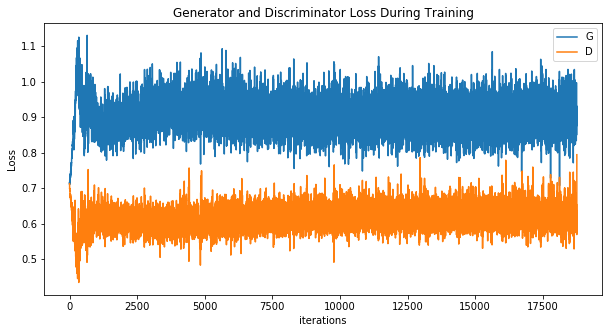

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

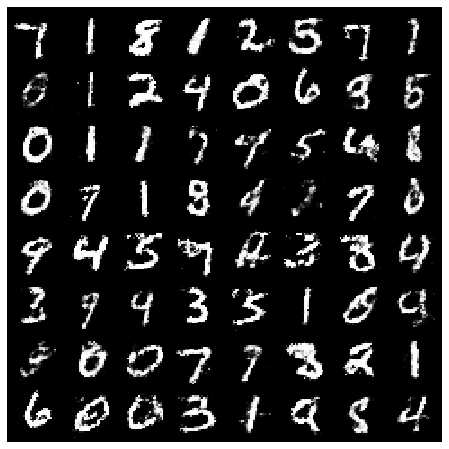

In [12]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

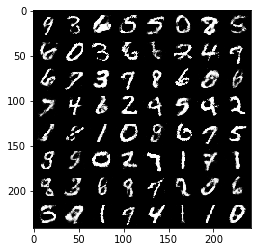

In [36]:
fixed_imgs = gnet(fixed_noise).detach().cpu()
img = torchvision.utils.make_grid(fixed_imgs, padding=2, normalize=True)
plt.figure()
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()